(00-backprop)=
# Backpropagation

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/00-backprop.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

In this notebook, we look at **backpropagation** (BP) on computational graphs. Breadth-first message passing of local gradients and activations result in a train step that has a time complexity that is linear in the number of edges of the graph. This fact allows scaling training large neural networks since it turns out that neural networks implement composition of differentiable functions (i.e. computational graphs with differentiable nodes). Moreover, the number of edges of neural networks as graphs is proportional to the total number of weights and activations. Understanding BP allows us to implement a minimal scalar-valued **autograd engine** and a neural net library on top it to train a small regression model.

**Readings:**  {cite}`timviera` {cite}`backprop-offconvex` {cite}`pytorch-autograd` {cite}`micrograd`


## Gradient descent on the loss surface

For every data point $(\boldsymbol{\mathsf x}, \mathsf{y})$, the loss function $\ell$ returns a nonnegative value that approaches zero whenever the predictions $f(\boldsymbol{\mathsf x}; {\boldsymbol{\Theta}})$ of the network $f$ given the current parameter values ${\boldsymbol{\Theta}}$ approach the target values $\mathsf y$. The loss is designed to give penalty to bad predictions depending on the context or problem setup. More precisely, the loss acts as an almost-everywhere differentiable surrogate to the true objective which is generally non-differentiable metric (e.g. accuracy).

### Gradient descent

Training neural networks is essentially an optimization problem with the loss as objective. Given the current parameters $\boldsymbol{\Theta} \in \mathbb R^d$ of the network, we can imagine the network to be sitting on a point $(\boldsymbol{\Theta}, \mathcal L(\boldsymbol{\Theta}))$ on a surface in $\mathbb R^d \times \mathbb R$ where $\mathcal L(\boldsymbol{\Theta})$ is the average loss over the dataset:

$$
\mathcal L(\boldsymbol{\Theta}) = \frac{1}{|\mathcal X|} \sum_{(\boldsymbol{\mathsf x}, \mathsf{y}) \in \mathcal X} \ell(\mathsf{y}, f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf x})).
$$

The surface will generally vary for different samples of the training data, but we except the surfaces to be similar for large enough samples that are independently drawn from the same distribution. Training is equivalent to finding the minimum of this surface. 
Gradients arise in deep learning when making the following first-order approximation to surface increment:

$$\Delta \mathcal L \approx  \sum_k \left(\frac{\partial \mathcal L}{ \partial {\Theta}_k} \right)  \Delta {\Theta}_k = \left( \nabla_{\boldsymbol{\Theta}}\, \mathcal L \right) \cdot \Delta {\boldsymbol{\Theta}}.$$ 

It follows that $-\nabla_{\boldsymbol{\Theta}}\, \mathcal L$ is the direction of steepest descent at the current point $(\boldsymbol{\Theta}, \mathcal L)$ in the surface. [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) (GD) is defined by the naive update rule: $\boldsymbol{\Theta} \leftarrow \boldsymbol{\Theta} - \eta \nabla_{\boldsymbol{\Theta}}\, \mathcal L$ where $\eta > 0.$ Note that finding [initial weights](03-weight-init) $\boldsymbol{\Theta}_0 \in \mathbb{R}^d$ for this iterative process can be crucial for networks with lots of internal symmetries for it to converge. For now we will focus on efficiently computing the weight gradients. Later on we will see that other optimization algorithms in deep learning practice are just modifications of GD.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')


def plot_loss_surface(X, y, loss, figsize=(6, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    N = 50
    row = np.linspace(-5, 5, N)
    XX, YY = np.meshgrid(row, row)
    ZZ = np.zeros_like(XX)
    for i in range(N):
        for j in range(N):
            ZZ[i, j] = loss(np.array([XX[i, j], YY[i, j]]), X, y)

    # Plot 3D surface 
    ax.plot_surface(XX, YY, ZZ, cmap='Reds') 
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    plt.show()

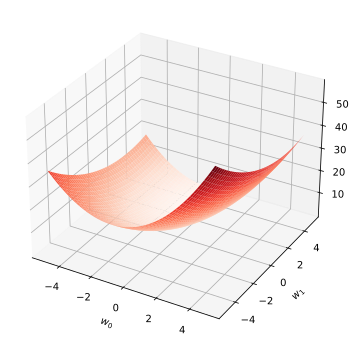

In [2]:
def loss(w, X, y):
    return ((X @ w - y)**2).mean()

# Generate data
n = 1000
X = np.zeros((n, 2))
X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
X[:, 0] = 1
w_min = np.array([-1, 3])
y = (X @ w_min) + 0.05 * np.random.randn(n)  # signal: y = -1 + 3x + noise

plot_loss_surface(X, y, loss)

**Figure.** Loss surface of a linear function with MSE loss.

### Optimization algorithms

The positive constant $\eta$ controls the step size in GD and is called the **learning rate**. Fixed learning rates can result in steps that overshoot the minimum or too slow convergence. This is why second-order methods which compute the [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix) exist since second derivatives are used to measure local surface curvature. But computing second derivatives is quadratic in the number of weights. Instead, combining adaptive learning rates and momentum {cite}`adam` {cite}`DBLP:journals/corr/Ruder16` with [learning rate scheduling](https://paperswithcode.com/methods/category/learning-rate-schedules) is more commonly used for large network training. For instance, the [`optim`](https://pytorch.org/docs/stable/optim.html) library in PyTorch is dedicated to implementing various modifications to GD and learning rate scheduling.

In [3]:
def grad(w, X, y):
    """Gradient step for the MSE loss function"""
    dw = 2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
    return dw / np.linalg.norm(dw)


def grad_descent(w0, X, y, eta=0.1, epochs=10):
    """Return sequence of weights from GD."""

    w = np.zeros([epochs, 2])
    w[0, :] = w0
    
    for j in range(1, epochs):
        u = w[j-1, :]
        w[j, :] = u - eta * grad(u, X, y)
        
    return w

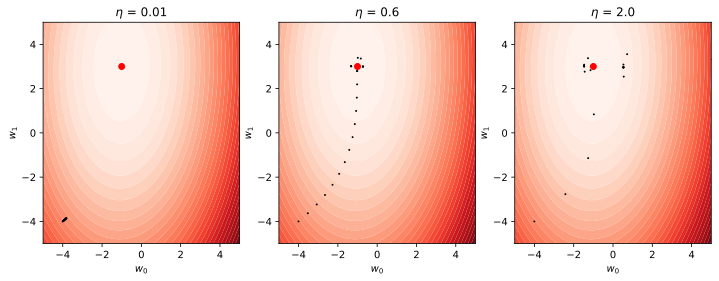

In [4]:
def plot_grad_descent(ax, X, y, w_min, w_hist):

    N = 50 # size of grid
    row = np.linspace(-5, 5, N)
    XX, YY = np.meshgrid(row, row)
    ZZ = np.zeros_like(XX)
    for i in range(N):
        for j in range(N):
            ZZ[i, j] = loss(np.array([XX[i, j], YY[i, j]]), X, y)
    
    # Plot 2D contour
    ax.contourf(XX, YY, ZZ, cmap='Reds', levels=30)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')

    ax.scatter(w_min[0], w_min[1], color="red", label='min')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=1, facecolors='k')


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

w_init = [-4, -4]
eta0, eta1, eta2 = 0.01, 0.60, 2.00
w0 = grad_descent(w_init, X, y, eta=eta0, epochs=25)
w1 = grad_descent(w_init, X, y, eta=0.60, epochs=25)
w2 = grad_descent(w_init, X, y, eta=2.00, epochs=25)

plot_grad_descent(ax[0], X, y, w_min, w0)
plot_grad_descent(ax[1], X, y, w_min, w1)
plot_grad_descent(ax[2], X, y, w_min, w2)

ax[0].set_title(f"$\eta$ = {eta0}", fontsize=12)
ax[1].set_title(f"$\eta$ = {eta1}", fontsize=12)
ax[2].set_title(f"$\eta$ = {eta2}", fontsize=12);

**Figure.** Fixed learning rate requires careful tuning. Adaptive learning rates update based on previous gradient values and only requires finding a good base learning rate.

## BP on computational graphs

A neural network can be modelled as a **directed acyclic graph** (DAG) of nodes that implements a function and can be extended to implement the calculation of the loss value for each training example and parameter values. Compute nodes simply implement a simple function of values of nodes that are directed to it. Note that computes nodes are not necessarily atomic functions. We will implement compute nodes at various levels of abstraction depending on design considerations. It can also simply store values as is the case for parameter nodes which ultimately determines the function. In particular, our goal is to obtain parameter node values such that the resulting function minimizes the expected empirical loss on our dataset.

```{figure} ../../img/compute.svg
---
width: 30%
name: compute
---
Compute and parameter node as input to another compute node. Note that parameter nodes always have zero fan-in.
```

Observe that we can always perturb the value of the loss node by perturbing the values in each node resulting in perturbations cascading up to the final loss node. Assuming each computation is differentiable, we can compute the partial derivative of the loss with respect to each graph node. This means that compute graphs are differentiable. This makes sense since compute graphs are nested differentiable functions applied on the input $\boldsymbol{\mathsf{x}}.$ In this section, we will look at an algorithm for computing partial derivatives of compute graphs.

### Forward pass

During forward pass all compute nodes are executed starting from the input nodes, which evaluates to the input vector $\boldsymbol{\mathsf x}$, up to the loss node with output values passed to child nodes. Note that the output value of each node is stored. This avoids recomputation for later nodes that depend on the same node and preserves network state for backward pass. This operation also builds the computational graph. 

**Remark.** Note that nodes which compute values independently of each other can execute in parallel (e.g. neural network layers {eq}`fully-connected-layer`). This parallelism can occur both in the batch dimension and the layer dimension. Operations which can be expressed as tensor operations can leverage massive parallelism in the GPU.

### Backward pass

The gradient of the loss with itself is 1 which we store. This serves as the base step. So for any other node in the graph, we can assume that the **global gradient** `∂L/∂v` for each node `v` that depends on `u` is already stored. On the other hand, the **local gradients** `∂v/∂u` are specified analytically based on the operation between `u` and `v` and computed at runtime. The gradient with respect to node `u` can be calculated using the chain rule:

$$
{\frac{\partial\mathcal L}{\partial {{\boldsymbol{\mathsf u}}}} } = \sum_{\boldsymbol{\mathsf v}} {{\frac{\partial\mathcal L}{\partial{{\boldsymbol{\mathsf v}}}}}} {{\frac{\partial{{\boldsymbol{\mathsf v}}}}{\partial {{\boldsymbol{\mathsf u}}}}}}.
$$

```{figure} ../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the global gradient for a single node. Note that gradient type is distinguished by color: **local** (red) and **global** (blue).
```

This can be visualized as gradients flowing to each network node from the loss node. The flow of gradients will end on parameter and input nodes which have zero fan-in. Global gradients are stored in each compute node in the `.grad` attribute for use by the next layer, along with node values obtained during forward pass which are used in local gradient computation. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients as these are computed as needed. Backward pass can be implemented roughly as follows:

```python
class CompGraph:
    # ...

    def backward():
        for node in self.nodes():
            node.grad = None

        self.loss_node.grad = 1.0
        self.loss_node.backward()


class Node:
    # ...

    def backward(self):
        for parent in self.parents:
            parent.grad += self.grad * self.local_grad(parent)
            parent.degree -= 1
            if parent.degree == 0:
                parent.backward()
```

Each node has to wait for all incoming gradients from dependent nodes before passing the gradient to its parents. This is done by having a `degree` attribute that tracks whether all gradients from its dependent nodes have accumulated to a parent node. A newly created node starts with zero degree and is incremented each time a child node is created from it. In particular, the loss node has degree zero. Here `self.grad` is the global gradient which is equal to `∂L/∂(self)` while the local gradient `self.local_grad` is equal to `∂(self)/∂(parent)`. So this checks out with the chain rule.

**Modularity.** BP is a useful tool for reasoning about gradient flow and can suggest ways to improve training or network design. Moreover, since it only requires local gradients between nodes, BP allows modularity when creating deep networks. Indeed, we can see from the deep learning literature that architectures typically consist of blocks of functionality.

## Creating and training a neural net from scratch

Recall that all operations must be defined with its local gradient specified for efficient BP to work. In this section, we will implement a minimal **autograd engine** for creating computational graphs. This starts with the base `Node` class which has a `.data` attribute for storing output and a `.grad` attribute for storing the global gradient. The base class defines a `backward` method to solve for `.grad` as described above.

Note that the node class does not implement a local gradient. Instances of the node class, such as input nodes and network weights, are called **leaf nodes**. Nodes implement all operations and activations which are inherited by outputs of these computations which we call **compute nodes**. The formula for local gradient in `_local_grad` must be implemented with respect to each parent node of the compute node.

In [5]:
import math
import random
random.seed(42)

from typing import final


class Node:
    def __init__(self, data, parents=()):
        self.data = data
        self.grad = 0             # ∂(loss)/∂(self)
        self._degree = 0          # no. of children
        self._parents = parents   # terminal node 

    @final
    def backward(self):
        """Send global grads backward to parent nodes."""
        for parent in self._parents:
            parent.grad += self.grad * self._local_grad(parent)
            parent._degree -= 1
            if parent._degree == 0:
                parent.backward()
    
    def _local_grad(self, parent) -> float: 
        """Compute local grads ∂(self)/∂(parent)."""
        raise NotImplementedError("Base node has no parents.")

    def __add__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='+')

    def __mul__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='*')

    def __pow__(self, n):
        assert isinstance(n, (int, float)) and n != 1
        self._degree += 1
        return PowOp(self, n)

    def relu(self):
        self._degree += 1
        return ReLUNode(self)

    def tanh(self):
        self._degree += 1
        return TanhNode(self)

    def __neg__(self):
        return self * Node(-1)

    def __sub__(self, other):
        return self + (-other)

Note that we can take advantage of reduction to minimize the operations for which we have to implement `_local_grad(self, parent)`. Below, we define the above operations between nodes. Observe that only a handful of operations are needed to implement a fully-connected neural net!

In [6]:
class BinaryOpNode(Node):
    def __init__(self, x, y, op: str):
        """Binary operation between two nodes."""
        ops = {
            '+': lambda x, y: x + y,
            '*': lambda x, y: x * y
        }
        self._op = op
        super().__init__(ops[op](x.data, y.data), (x, y)) 

    def _local_grad(self, parent):
        if self._op == '+':
            return 1.0
                    
        elif self._op == '*':
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data

    def __repr__(self):
        return self._op


class ReLUNode(Node):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return float(parent.data > 0)

    def __repr__(self):
        return 'relu'


class TanhNode(Node):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return 1 - self.data**2

    def __repr__(self):
        return 'tanh'


class PowOp(Node):
    def __init__(self, x, n):
        self.n = n
        data = x.data ** self.n
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

    def __repr__(self):
        return f"** {self.n}"

### Graph vizualization

The next two functions help to visualize networks. The `trace` function just walks backward into the graph to collect all nodes and edges. This is used by the `draw_graph` which first draws all nodes, then draws all edges. For compute nodes we add a small juncture node which contains the name of the operation.

In [7]:
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in a graph."""

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._parents:
                edges.add((child, v))
                build(child)
                    
    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:

        # Add node to graph    
        uid = str(id(n))
        dot.node(name=uid, label=f"data={n.data:.3f} | grad={n.grad:.4f} | deg={n._degree}", shape='record')
        
        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if len(n._parents) > 0:
            dot.node(name=uid+str(n), label=str(n))
            dot.edge(uid+str(n), uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + str(v))
    
    return dot

Creating graph for a dense unit. Observe that `x1` has a degree of 2 since it has two children.

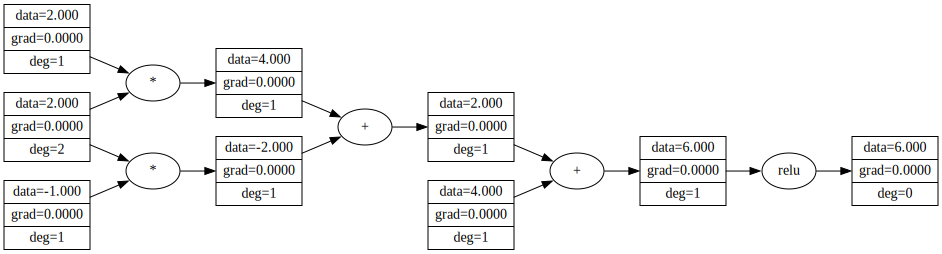

In [8]:
w1 = Node(-1.0)
w2 = Node(2.0)
b  = Node(4.0)
x  = Node(2.0)
t  = Node(3.0)

z = w1 * x + w2 * x + b
y = z.relu()
draw_graph(y)

Backward pass can be done by setting the initial gradient of the final node, then calling backward on it. Recall for the loss node `loss.grad = 1.0`. Observe that all gradients check out. Also, all degrees are zero, which means we did not overshoot the updates. This also means we can't execute `.backward()` twice.

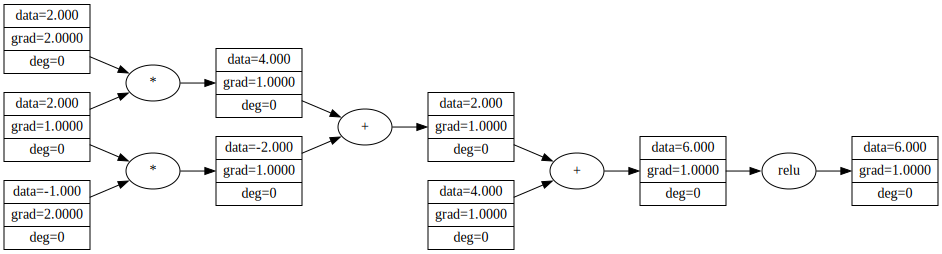

In [9]:
y.grad = 1.0
y.backward()
draw_graph(y)

### Neural network

In this section, we will construct the neural network module incrementally. `Module` defines an abstract class which for maintaining a list of the parameter nodes used that implements forward pass in the `__call__` method. Having the decorator `@final` prevents the inheriting class from overriding the `parameters()` method. Doing so would result in a warning or an error with a type checker. This encourages defining `self._parameters` attribute so that the parameters list is not constructed at each call of the `parameters()` method.

In [10]:
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._parameters = []

    @final
    def parameters(self) -> list:
        return self._parameters

    @abstractmethod
    def __call__(self, x: list):
        pass

    @final
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

Note that it also implements the `zero_grad` method which is convenient for clearing out gradients. The following implements [neural networks](https://en.wikipedia.org/wiki/Multilayer_perceptron) starting from **neurons** to **layers**:

In [11]:
import numpy as np
np.random.seed(42)


class Neuron(Module):
    def __init__(self, n_in, nonlinear=True, activation='relu'):
        self.n_in = n_in
        self.act = activation
        self.nonlin = nonlinear

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b] 

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.nonlin:
            if self.act == 'tanh':
                out = out.tanh()
            elif self.act == 'relu':
                out = out.relu()
            else:
                raise NotImplementedError("Activation not supported.")
        return out

    def __repr__(self):
        return f"{self.act if self.nonlin else 'linear'}({len(self.w)})"


class Layer(Module):
    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, n_in, n_outs, activation='relu'):
        sizes = [n_in] + n_outs
        self.layers = [Layer(sizes[i], sizes[i+1], i < len(n_outs)-1, activation) for i in range(len(n_outs))]
        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call. Note that final node has no activation:

In [12]:
model = MLP(n_in=1, n_outs=[2, 2, 1])
print(model)
x = Node(1.0)
pred = model([x])
print(pred.data)

MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2)], Layer[linear(2)]]
0.20429304314825944


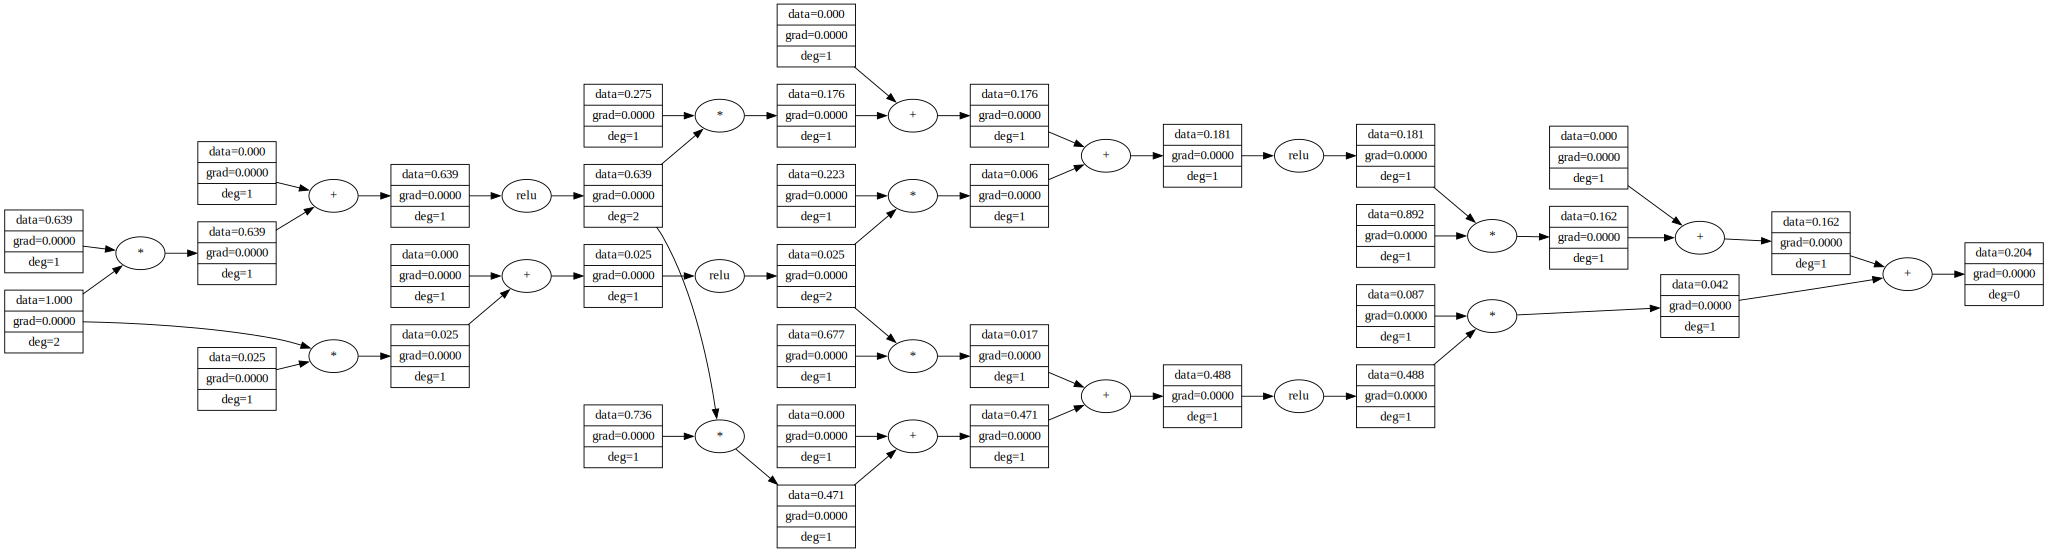

In [13]:
draw_graph(pred)

(00-nn-benchmark)=
### Benchmarking

Function evaluation has time and memory complexity that is **linear** in the number of edges of the graph. This assumes each node executes in constant time and the outputs are stored. Moreover, the gradient should never be asymptotically slower than the function assuming local gradient computation takes constant time. This works in both cases because no edge is counted twice and intermediate results are cached. Notice that the memory requirement for backward can be further optimized by releasing the gradient after weights in the next layer updates.

100%|██████████| 14/14 [02:39<00:00, 11.40s/it]


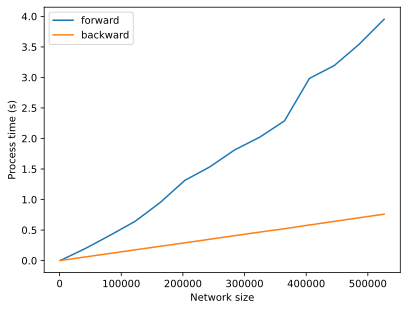

In [14]:
import tqdm
import time

x = [Node(1.0)] * 3
network_size  = []
forward_time  = []
backward_time = []

for i in tqdm.tqdm(range(1, 15)):
    nouts = [200] * i + [1]
    model = MLP(n_in=3, n_outs=nouts)
    
    f_timings = []
    b_timings = []
    
    for i in range(5):
        start = time.process_time()
        pred = model(x)
        end = time.process_time()
        f_timings.append(end - start)

        pred.grad = 1.0
        start = time.process_time()
        pred.backward()
        end = time.process_time()
        b_timings.append(end - start)

    network_size.append(len(model.parameters()) + sum(nouts) + 3)
    forward_time.append(sum(f_timings[1:]) / 4)
    backward_time.append(sum(b_timings[1:]) / 4)


plt.plot(network_size, forward_time, label='forward')
plt.plot(network_size, backward_time, label='backward')
plt.xlabel("Network size")
plt.ylabel("Process time (s)")
plt.legend();

**Figure.** Roughly linear time complexity in network size for both forward and backward passes on a scalar valued neural net on the CPU. Note that the number of edges is roughly the number of activation and weight nodes in a neural net.

### Training the network!

To train a neural network that computes a function $f$, we can think of appending an extra node for the target values, and another compute node for the loss function. The node for the loss takes the output $f(\boldsymbol{\mathsf x})$ and target $\mathsf y$ for each input output pair $(\boldsymbol{\mathsf x}, {\mathsf y})$ in a training step. After computing the global gradients by backpropagation, we update the weights using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with `λ=0.0001`. SGD is just gradient descent combined with random sampling. 


**Dataset.** Our task is to learn the following signal consisting of 200 data points:

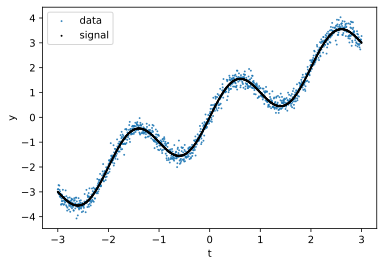

In [15]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

N = 1200
time = np.linspace(-3, 3, N)
y_signal = time + np.sin(np.pi * time)
y_data = y_signal + 0.2 * np.random.normal(size=N)

plt.figure(figsize=(6, 4))
plt.scatter(time, y_data, label='data', s=1, alpha=0.8)
plt.scatter(time, y_signal, s=1, color='k', label='signal')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

**Data loader.** Helper for loading the samples:

In [16]:
import random

class DataLoader:
    def __init__(self, dataset):
        """Iterate over a partition of the dataset."""
        self.dataset = [(Node(x), Node(y)) for x, y in dataset]
    
    def load(self):
        return random.sample(self.dataset, len(self.dataset))

    def __len__(self):
        return len(self.dataset)

**Training.** The function `optim_step` implements one step of gradient descent. SGD uses a batch size of 1, so `loss_fn` just computes the MSE between two nodes.

In [17]:
def optim_step(model, eps):
    for p in model.parameters():
        p.data -= eps * p.grad 

def loss_fn(y_pred, y_true):
    return (y_pred - y_true)**2

Running the training algorithm:

In [18]:
def train(model, dataset, epochs):
    dataloader = DataLoader(dataset)
    history = []
    for _ in tqdm.tqdm(range(epochs)):
        for x, y in dataloader.load():
            model.zero_grad()
            
            loss = loss_fn(model([x]), y)
            loss.grad = 1.0
            loss.backward()
            optim_step(model, eps=0.0001)

            history.append(loss.data)

    return history


dataset = list(zip(time, y_data))
model = MLP(1, [3, 3, 1], 'tanh')
loss = train(model, dataset, epochs=15000)

100%|██████████| 15000/15000 [22:04<00:00, 11.32it/s]


Observe that the loss curve becomes more stable as we train futher:

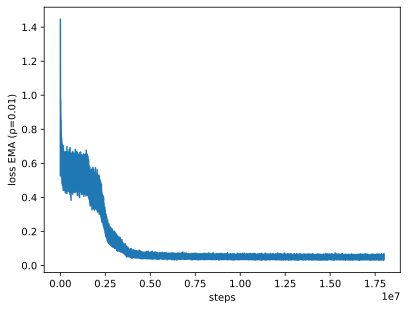

In [19]:
ρ = 0.01
loss_ema = [loss[0]]
for i in range(1, len(loss)):
    loss_ema.append(loss_ema[i-1] * (1 - ρ) + loss[i] * ρ)

plt.plot(loss_ema)
plt.ylabel(f"loss EMA (ρ={ρ})")
plt.xlabel("steps");

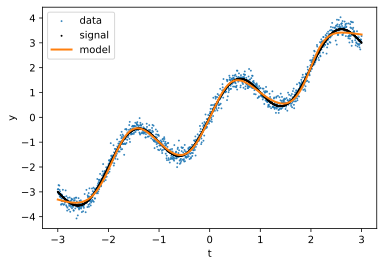

In [20]:
plt.figure(figsize=(6, 4))
plt.scatter(time, y_data, label='data', s=1, alpha=0.8)
plt.scatter(time, y_signal, s=1, color='k', label='signal')
plt.plot(time, [model([Node(_)]).data for _ in time], label='model', color='C1', linewidth=2)

plt.ylabel('y')
plt.xlabel('t')
plt.legend();

Evaluating with MAE since values are in (0, 1):

In [21]:
y_pred = np.array([model([Node(_)]).data for _ in time])
print(f"MAE (signal): {np.abs(y_pred - y_signal).mean():.2f}")
print(f"MAE (data):   {np.abs(y_pred - y_data  ).mean():.2f}")

MAE (signal): 0.06
MAE (data):   0.17


## Appendix: Testing with `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined above for BP.

**Scalars.** Here we calculate $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\boldsymbol{\mathsf{x}}_i}^2$ where the initialized tensor $\boldsymbol{\mathsf{x}}$ initially has no gradient (i.e. `None`). Calling backward on $\mathsf{y}$ results in gradients being stored on the leaf tensor $\boldsymbol{\mathsf{x}}.$ Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as $\mathsf{y}$ is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph.

In [22]:
import torch
import torch.nn.functional as F
print(torch.__version__)

1.13.0


In [23]:
x = torch.arange(4, dtype=torch.float, requires_grad=True)
print(x.grad)

y = x.T @ x 
y.backward() 
print((x.grad == 2*x).all().item())

None
True


/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/ipykernel_27641/4003643635.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  y = x.T @ x


**Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{{\mathsf v}}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` implements   

$$\sum_i {\boldsymbol{\mathsf v}}_i \frac{\partial {\boldsymbol{\mathsf y}}_i}{\partial {\boldsymbol{\mathsf x}}_j}$$ 
  
resulting in a vector of same length as $\boldsymbol{\mathsf{x}}$ stored in `x.grad`. Note that the terms on the right are the local gradients in backprop. Hence, if $\boldsymbol{\mathsf{v}}$ contains backpropagated gradients of nodes that depend on $\boldsymbol{\mathsf{u}}$, then this operation gives us the backpropagated gradients with respect to $\boldsymbol{\mathsf{x}}$, i.e. setting ${\boldsymbol{\mathsf v}}_i = \frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf y}_i}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf x}_j}.$

In [24]:
x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor(
    [[1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all()

tensor(True)

**Remark.** Gradient computation is not useful for tensors that is not part of backprop. Hence, we can wrap our code in a `torch.no_grad()` context or inside a function with a `@torch.no_grad()` decorator. Note that the `.detach()` method returns a new tensor detached from the current graph but shares the same storage with the original one. In-place modifications on either tensor can result in subtle bugs.

### Testing

Finally, we write our tests with `autograd` to check the correctness of our implementation:

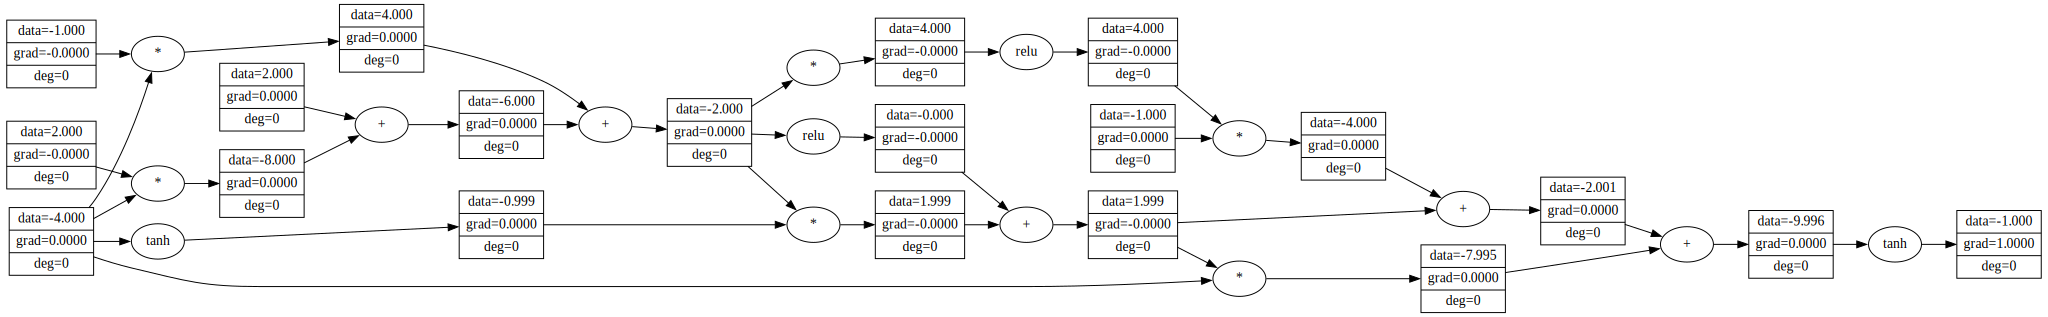

In [25]:
x = Node(-4.0)
z = Node(2) * x + Node(2) - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()
y.grad = 1.0
y.backward()

x_node, y_node, z_node = x, y, z
draw_graph(y_node)

In [26]:
x = torch.tensor(-4.0, requires_grad=True)
z = 2 * x + 2 - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()

z.retain_grad()
y.retain_grad()
y.backward()

x_torch, y_torch, z_torch = x, y, z

# forward
errors = []
errors.append(abs(x_node.data - x_torch.item()))
errors.append(abs(y_node.data - y_torch.item()))
errors.append(abs(z_node.data - z_torch.item()))

# backward
errors.append(abs(x_node.grad - x_torch.grad.item()))
errors.append(abs(y_node.grad - y_torch.grad.item()))
errors.append(abs(z_node.grad - z_torch.grad.item()))

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 7.48e-08


(00-backprop:appendix-backpropagation-equations-for-mlps)=
## Appendix: BP equations for MLPs

In this section, we solve the backprop equations for a fully-connected neural net. This can be useful for analyzing gradient flow during training. Recall that a fully-connected layer with weights $\boldsymbol{\mathsf{w}}_{ij}$ and bias $\boldsymbol{\mathsf{b}}_j$ computes $\boldsymbol{\mathsf{y}}_j = \varphi(\sum_i \boldsymbol{\mathsf{x}}_i \boldsymbol{\mathsf{w}}_{ij} + \boldsymbol{\mathsf{b}}_j).$ The gradients can be nicely computed using [Einstein summation](https://www.dr-qubit.org/teaching/summation_delta.pdf) and dissecting the formula following its intermediate steps: 

```{math}
:label: fully-connected-layer
\begin{aligned}
\boldsymbol{\mathsf{y}}_j &= \varphi(\boldsymbol{\mathsf{z}}_j) \\ 
\boldsymbol{\mathsf{z}}_j &= \sum_i \boldsymbol{\mathsf{x}}_i \boldsymbol{\mathsf{w}}_{ij} + \boldsymbol{\mathsf{b}}_j.
\end{aligned}
```

Given global gradients ${\partial \mathcal{L}}/{\partial \boldsymbol{\mathsf{z}}_j}$ that flows into the layer, we compute the global gradients of the nodes $\boldsymbol{\mathsf{z}}, \boldsymbol{\mathsf{x}}, \boldsymbol{\mathsf{w}},$ and $\boldsymbol{\mathsf{b}}$ in the layer. As discussed above, this can be done by carefully tracking backward dependencies in the compute graph.

```{figure} ../../img/fully-connected-backprop.drawio.svg
---
name: fully-connected-backprop.drawio
width: 50%
---
Node dependencies in compute nodes of a fully connected layer. All nodes $\boldsymbol{\mathsf{z}}_k$ depend on the node $\boldsymbol{\mathsf{y}}_j.$
```


Note that there can be cross-dependencies on activations such as softmax. But for typical activation functions the [Jacobian](https://mathworld.wolfram.com/Jacobian.html) ${\boldsymbol{\mathsf{J}}}^{\varphi}_{jk} = \frac{\partial \boldsymbol{\mathsf{y}}_j}{\partial \boldsymbol{\mathsf{z}}_k}$ of $\varphi$ reduces to a diagonal matrix. Following backward dependencies ({numref}`fully-connected-backprop.drawio`) for the compute nodes:

```{math}
:label: backprop-output
\begin{aligned}
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} &= \sum_k \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{y}}_k}  \frac{\partial \boldsymbol{\mathsf{y}}_k}{\partial \boldsymbol{\mathsf{z}}_j} =  \sum_k \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{y}}_k} \boldsymbol{\mathsf{J}}^{\varphi}_{kj} \\
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{x}}_i} &= \sum_j \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} \frac{\partial \boldsymbol{\mathsf{z}}_j}{\partial \boldsymbol{\mathsf{x}}_i} = \sum_j \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} \boldsymbol{\mathsf{w}}_{ij} = \sum_j \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_j} \boldsymbol{\mathsf{w}}_{ji}^{\top}.
\end{aligned}
```

In the above equations, we suppressed the batch index since the operations can be carried out entirely within one instance of a batch. But observe that while only one preactivation node $\boldsymbol{\mathsf{z}}_j$ depends on the parameters $\boldsymbol{\mathsf{w}}_{ij}$ and $\boldsymbol{\mathsf{b}}_j$, all instances of that compute node within the batch depend on the current value of the parameter nodes. Hence, we have to account for dependence along the batch dimension when solving for their gradients:

```{math}
:label: backprop-weights
\begin{aligned}
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{w}}_{ij}} &= \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \frac{\partial \boldsymbol{\mathsf{z}}_{bj}}{\partial \boldsymbol{\mathsf{w}}_{ij}} 
= 
\sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \boldsymbol{\mathsf{x}}_{bi} 
= 
\sum_b \boldsymbol{\mathsf{x}}_{ib}^{\top}\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}} \\
\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{b}}_{j}} &= \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}}  \frac{\partial \boldsymbol{\mathsf{z}}_{bj}} {\partial \boldsymbol{\mathsf{b}}_{j}}  =  \sum_b\frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{z}}_{bj}}.
\end{aligned}
```

This equation shows that the weight gradient depends on the gradient of the output (i.e. how the value output node directly influences the loss value) weighted by the input. Note that the parameter gradients {eq}`backprop-weights` are effectively weighted by $\frac{\lambda}{B}$ where $\lambda$ is the learning rate and $B$ is batch size in the optimization update when the loss undergoes mean reduction. This also explains why we want to standardize inputs to the network and layer inputs. Otherwise, we effectively introduce multipliers to the learning rate on each input dimension.

```{figure} ../../img/weight-backprop.drawio.svg
---
name: weight-backprop.drawio
width: 30%
---
Node dependencies for a weight node. The nodes $\boldsymbol{\mathsf{z}}_{bj}$ depend on $\boldsymbol{\mathsf{w}}_{ij}$ for $b = 1, \ldots, B.$
```


### Cross entropy

In this section, we compute the gradient across the **cross-entropy** loss by symbolically differentiating its formula. This can be faster to perform and generally results in a cleaner and optimized formula than doing chain rule for all intermediate computation that each requires matrix multiplication if not simplified. Recall that [cross-entropy loss with logits](02-keras:api-for-cross-entropy) $\boldsymbol{\mathsf{s}}_{bj}$ computes 

$$
\begin{aligned}
\mathcal{L} 
&= -\frac{1}{B} \sum_b \log \frac{e^{\boldsymbol{\mathsf{s}}_{bt_b}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj}}} \\
&= -\frac{1}{B} \sum_b \left({\boldsymbol{\mathsf{s}}_{bt_b}} - \log \sum_j e^{\boldsymbol{\mathsf{s}}_{bj}} \right)
\\
&= -\frac{1}{B} \sum_b \left({\boldsymbol{\mathsf{s}}_{bt_b}} - \boldsymbol{\mathsf{s}}_{bj^*} - \log \sum_j e^{\boldsymbol{\mathsf{s}}_{bj} - \boldsymbol{\mathsf{s}}_{bj^*}} \right)
\end{aligned}
$$

where $\boldsymbol{\mathsf{s}}_{bj^*} = \max_j \boldsymbol{\mathsf{s}}_{bj}.$ This can be further decomposed into intermediate computations to get easier to compute derivatives. But this looks manageable. Our goal is to compute the derivative that flows to the logits $\boldsymbol{\mathsf{s}}_j.$ We differentiate the second equation above:

$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{s}}_{bk}}
&= -\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \frac{e^{\boldsymbol{\mathsf{s}}_{bk}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj}}}\right) = -\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \frac{e^{\boldsymbol{\mathsf{s}}_{bk} - \boldsymbol{\mathsf{s}}_{bj^*}}}{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj} - \boldsymbol{\mathsf{s}}_{bj^*}}}\right)
\end{aligned}
$$

where $\boldsymbol{\delta}_{t_bk}$ denotes the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) tensor. Note that we adjust the exponentials for numerical stability similar to the last equality for $\mathcal L.$ It follows that 

$$
-\frac{\partial\mathcal{L}}{\partial\boldsymbol{\mathsf{s}}_{bk}} 
=
-\frac{1}{B}\left(\boldsymbol{\delta}_{t_bk} - \boldsymbol{\mathsf{p}}_{bk} \right)
= 
\frac{1}{B}\begin{cases}
1 - \boldsymbol{\mathsf{p}}_{bt_b} & \;\; k = t_b \\
\boldsymbol{-\mathsf{p}}_{bj} & \;\; k \neq t_b.
\end{cases}
$$ 

where $\boldsymbol{\mathsf{p}}_{bt_b} = {e^{\boldsymbol{\mathsf{s}}_{bt_b} }}/{\sum_j e^{\boldsymbol{\mathsf{s}}_{bj} }}$ are the predict probabilities. Here we take the negative of the gradients to orient us in the direction of decreasing loss. Note that the negative gradient of the logit of the true class is always either positive or zero, while those of the other classes are always negative or zero. Moreover, the magnitude of the gradient of true class is equal to the magnitude of the other gradients combined.

**Dynamics of weight updates.** A neural network can be viewed as an extremely complex system (sort of like a pulley system) where adjusting one weight ultimately results in adjusting the positions of succeeding activation components up to the final loss. Since we are using gradient descent, we consider the first-order effect on the loss of perturbing a weight variable $\boldsymbol{\mathsf{w}}$ with all other weights of the system fixed. In particular, we consider its effects on the logits which are the outermost exposed neurons of the network:

$$
\begin{aligned}
-\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{w}}} 
&= -\sum_b\sum_k\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{s}}_{bk}} \frac{\partial \boldsymbol{\mathsf{s}}_{bk}}{\partial \boldsymbol{\mathsf{w}}} 
\\
&= -\frac{1}{B}\sum_b\sum_k\left(\boldsymbol{\delta}_{t_bk} - \boldsymbol{\mathsf{p}}_{bk} \right) \frac{\partial \boldsymbol{\mathsf{s}}_{bk}}{\partial \boldsymbol{\mathsf{w}}} \\
&= \frac{1}{B}\sum_b\left[(1 - \boldsymbol{\mathsf{p}}_{t_b}) \frac{\partial \boldsymbol{\mathsf{s}}_{t_b}}{\partial \boldsymbol{\mathsf{w}}} + \sum_{k \neq t_b} \boldsymbol{\mathsf{p}}_k \left(-\frac{\partial \boldsymbol{\mathsf{s}}_k}{\partial \boldsymbol{\mathsf{w}}}\right) \right].
\end{aligned}
$$ 

It follows that update for $\boldsymbol{\mathsf{w}}$ depends on how much it ultimately increases the true logits and decreases the other logits weighted by how close the probabilities are to the one-hot vector of the true class (i.e. the ideal probability vector) for that instance. In other words, if $\boldsymbol{\delta}_{t_b} \approx \boldsymbol{\mathsf{p}}_{b}$ for all $b$ in the batch, then the weight update $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{w}}}$ is close to zero. This makes sense from a stability perspective.

In [27]:
B = 32
N = 27
t = torch.randint(low=0, high=N, size=(B,))
x = torch.randn(B, 128, requires_grad=True)
w = torch.randn(128, N, requires_grad=True)
b = torch.randn(N,      requires_grad=True)
z = x @ w + b
y = torch.tanh(z)

for node in [x, w, b, z, y]:
    node.retain_grad()

# Cross-entropy with logits y
loss = -torch.log(F.softmax(y, dim=1)[range(B), t]).sum() / B
loss.backward()

Plotting the gradient of the logits:

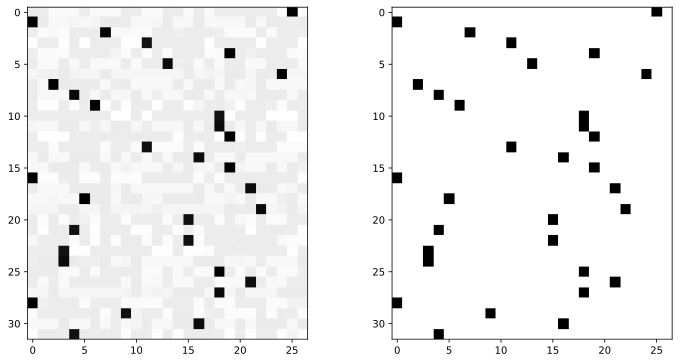

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(y.grad.detach().numpy() * B, cmap="gray")
ax[1].imshow(-F.one_hot(t, num_classes=N).detach().numpy(), cmap="gray");

**Figure.** Here ■ = 1, □ = 0. Plotted in the left are the gradient of the logits for the given batch. See above discussion. The actual targets are shown on the right. Each row of the update matrix sums to zero:

In [29]:
y.grad.sum(dim=1, keepdim=True).abs().mean()

tensor(1.7008e-09)

### Gradient checking

The above equations can be vectorized quite easily with the convention that the gradient with respect to a tensor $\boldsymbol{\mathsf{v}}$ has the same shape as $\boldsymbol{\mathsf{v}}.$ Let $\boldsymbol{\mathsf{v}}_\nabla = \frac{\partial \mathcal L}{\partial \boldsymbol{\mathsf{v}}}$ (i.e. `v.grad` in PyTorch code). Then we can write $\boldsymbol{\mathsf{x}}_\nabla = \boldsymbol{\mathsf{y}}_\nabla\,  \boldsymbol{\mathsf{w}}^\top$ since the input tensor $\boldsymbol{\mathsf{x}}$ is a row vector. For the sake of demonstration, we use a batch size of 32. This computation should give us an intuition of how gradients flow backwards through the neural net starting from the loss to all intermediate results.

In [30]:
J = 1 - y**2                        # Jacobian
δ_tk = F.one_hot(t, num_classes=N)  # Kronecker delta
dy = - (1 / B) * (δ_tk - F.softmax(y, dim=1))
dz = dy * J
dx = dz @ w.T
dw = x.T @ dz
db = dz.sum(0, keepdim=True)

These equations can be checked using `autograd` as follows. Note that the computed gradients are inexact perhaps due to optimization in softmax. This can be seen above where we saw that the sum of gradients of the logits computed using `autograd` is nonzero.

In [31]:
def compare(name, dt, t):
    exact  = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, rtol=1e-5)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{name:<3s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {maxdiff:.2e}')


compare('y', dy, y)
compare('z', dz, z)
compare('x', dx, x)
compare('w', dw, w)
compare('b', db, b)

y   | exact: False | approx: True  | maxdiff: 1.86e-09
z   | exact: False | approx: True  | maxdiff: 1.86e-09
x   | exact: False | approx: True  | maxdiff: 7.45e-09
w   | exact: False | approx: True  | maxdiff: 7.45e-09
b   | exact: False | approx: True  | maxdiff: 1.86e-09
